In [1]:
from pulp import *
import pandas as pd
import numpy as np

from tqdm.notebook import trange, tqdm

In [33]:
data=pd.read_csv('opti_set_k10_check3.csv')

In [34]:
data

,Unnamed: 0,ROIY3,mean_arr,std_arr,valuation0,Region_APAC,Region_EU,Region_MEA,Region_NAM,Sector_Banks,...,ARR1_XGBRegressor,ARR2_XGBRegressor,ARR3_XGBRegressor,ARR_mean_XGBRegressor,ARR_std_XGBRegressor,cluster,ARR_mean_cluster_XGBRegressor,ARR_std_cluster_XGBRegressor,ARR_mean_cluster,ARR_std_cluster
0,1556,2.784469,0.096855,0.268497,70621408.0,0,1,0,0,0,...,0.061822,0.049708,0.297102,0.136211,0.139468,7,0.216889,0.159763,0.216889,0.159763
1,526,2.424847,0.952605,0.810956,226778040.0,0,0,0,1,0,...,1.943363,0.557443,0.293146,0.931317,0.886363,1,0.969414,0.795893,0.969414,0.795893
2,393,1.574459,0.385684,0.289186,323040928.0,0,0,0,1,0,...,0.161769,0.076753,0.042865,0.093796,0.061256,4,0.032066,0.085522,0.032066,0.085522
3,1789,1.500066,0.151050,0.090030,23417634.0,0,1,0,0,0,...,0.107098,0.011984,0.005780,0.041621,0.056790,4,0.032066,0.085522,0.032066,0.085522
4,433,0.773358,-0.081643,0.007366,643587653.0,0,0,0,1,0,...,0.106246,-0.011550,0.153952,0.082883,0.085189,4,0.032066,0.085522,0.032066,0.085522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,838,0.572330,0.065408,0.226231,65073051.0,0,0,0,1,0,...,-0.004527,-0.002575,-0.039195,-0.015432,0.020602,4,0.032066,0.085522,0.032066,0.085522
602,1221,1.274035,0.239817,0.181746,185315348.0,0,1,0,0,0,...,0.503555,0.216175,0.091693,0.270474,0.211232,7,0.216889,0.159763,0.216889,0.159763
603,845,1.904087,0.695340,0.590249,178552374.0,0,1,0,0,0,...,0.958802,0.452334,0.589527,0.666887,0.261947,2,0.426380,0.279393,0.426380,0.279393
604,575,0.825062,-0.133320,0.068761,266534388.0,0,0,0,1,0,...,-0.038138,-0.154039,-0.089148,-0.093775,0.058089,0,-0.151358,0.077222,-0.151358,0.077222


In [4]:
def run_optim_all(data,gamma,n,sector,region,budget,max_inv,min_inv):
    res_pred_xgb=opti_model("pred_xgb",data,gamma,n,sector,region,budget,max_inv,min_inv)
    #res_pred_rf=opti_model("pred_rf",data,gamma,n,sector,region,budget,max_inv,min_inv)
    #res_pred_oct=opti_model("pred_oct",data,gamma,n,sector,region,budget,max_inv,min_inv)
    #res_pred_lasso=opti_model("pred_lasso",data,gamma,n,sector,region,budget,max_inv,min_inv)
    #res_pred_cart=opti_model("pred_cart",data,gamma,n,sector,region,budget,max_inv,min_inv)
    
    res_base=opti_model("baseline",data,gamma,n,sector,region,budget,max_inv,min_inv)
    res_ideal=opti_model("ideal",data,gamma,n,sector,region,budget,max_inv,min_inv)
    
    roi_pred_xgb=(data.iloc[res_pred_xgb>0].ROIY3*res_pred_xgb[res_pred_xgb>0]).sum()/budget
    #roi_pred_rf=(data.iloc[res_pred_rf>0].ROIY3*res_pred_rf[res_pred_rf>0]).sum()/budget
    #roi_pred_oct=(data.iloc[res_pred_oct>0].ROIY3*res_pred_oct[res_pred_oct>0]).sum()/budget
    #roi_pred_lasso=(data.iloc[res_pred_lasso>0].ROIY3*res_pred_lasso[res_pred_lasso>0]).sum()/budget
    #roi_pred_cart=(data.iloc[res_pred_cart>0].ROIY3*res_pred_cart[res_pred_cart>0]).sum()/budget
    
    roi_base=(data.iloc[res_base>0].ROIY3*res_base[res_base>0]).sum()/budget
    roi_ideal=(data.iloc[res_ideal>0].ROIY3*res_ideal[res_ideal>0]).sum()/budget    
    return {"pred_xgb":roi_pred_xgb,\
            #"pred_rf":roi_pred_rf,\
            #"pred_cart":roi_pred_cart,\
            #"pred_lasso":roi_pred_lasso,\
            #"pred_oct":roi_pred_oct,\
            "baseline":roi_base,\
            "ideal":roi_ideal}

In [11]:
def get_min_max_stake(value):
    if value <= 20000000:
        return (0.25,0.4)
    if (value >20000000) & (value <=100000000):
        return (0.15,0.35)
    else:
        return (0.10,0.30)

def opti_model(mode,data,gamma,n,sector,region,budget,max_inv,min_inv):

    prob = LpProblem("PE_Portfolio", LpMaximize)
    x = pulp.LpVariable.dicts("investment", range(n),  cat="Continuous")
    z = pulp.LpVariable.dicts("selection", range(n),  cat="Binary")
    
    for i in range(n): 
        prob+=x[i]<= get_min_max_stake(data.valuation0.iloc[i])[1]*data.valuation0.iloc[i]*z[i]*data[region].iloc[i].max()*data[sector].iloc[i].max()
        prob+=x[i]>= get_min_max_stake(data.valuation0.iloc[i])[0]*data.valuation0.iloc[i]*z[i]*data[region].iloc[i].max()*data[sector].iloc[i].max()

    prob+= lpSum([x[i] for i in range(n)])<=budget
    prob+= lpSum([z[i]*data[region].iloc[i].max()*data[sector].iloc[i].max() for i in range(n)])<=max_inv
    prob+= lpSum([z[i]*data[region].iloc[i].max()*data[sector].iloc[i].max() for i in range(n)])>=min_inv

    if mode=="pred_xgb":
        prob+=lpSum([(data["ARR_mean_cluster_XGBRegressor"].iloc[i]-gamma*data["ARR_std_cluster_XGBRegressor"].iloc[i])*x[i]\
                 for i in range(n)])
    
    if mode=="pred_rf":
        prob+=lpSum([(data["ARR_mean_cluster_RandomForestRegressor"].iloc[i]-gamma*data["ARR_std_cluster_RandomForestRegressor"].iloc[i])*x[i]\
                 for i in range(n)])
    if mode=="pred_oct":
        prob+=lpSum([(data["ARR_mean_cluster_OptimalTreeRegressor"].iloc[i]-gamma*data["ARR_std_cluster_OptimalTreeRegressor"].iloc[i])*x[i]\
                 for i in range(n)])    
    if mode=="pred_lasso":
        prob+=lpSum([(data["ARR_mean_cluster_Lasso"].iloc[i]-gamma*data["ARR_std_cluster_Lasso"].iloc[i])*x[i]\
                 for i in range(n)])
        
    if mode=="pred_cart":
        prob+=lpSum([(data["ARR_mean_cluster_DecisionTreeRegressor"].iloc[i]-gamma*data["ARR_std_cluster_DecisionTreeRegressor"].iloc[i])*x[i]\
                 for i in range(n)])
        
    if mode=="baseline":
        prob+=lpSum([(data["valuation0"].iloc[i])*x[i]\
                 for i in range(n)])
    if mode=="ideal":
        prob+=lpSum([(data["ROIY3"].iloc[i])*x[i]\
                 for i in range(n)])
    
   

    prob.solve()
    #print(LpStatus[prob.status])
    
    #if (LpStatus[prob.status])!='Optimal':
    #    return np.zeros(n)
    return np.array([x[i].varValue for i in range(n)])


In [35]:
gamma=0.3
n=data.shape[0]
#sector=["Sector_Machinery, equipment, furniture, recycling"]
sector=[col for col in data if col.startswith('Sector')]
region=["Region_NAM"]
budget=500000000
min_inv=10
max_inv=20

result=[]

## Budget
#for b in tqdm(np.linspace(10e7,10e9,20)):
#    record=run_optim_all(data,gamma,n,sector,region,b,max_inv,min_inv)
#    record["budget"]=b
#    result.append(record)

## Gamma
for g in tqdm(np.linspace(0,2,20)):
    record=run_optim_all(data,g,n,sector,region,budget,max_inv,min_inv)
    record["gamma"]=g
    result.append(record)

## Min Inv
#for m_i in tqdm(range(15)):
#    record=run_optim_all(data,gamma,n,sector,region,budget,m_i+10,m_i)
#    record["no_inv"]="[{},{}]".format(m_i,m_i+10)
#    result.append(record)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


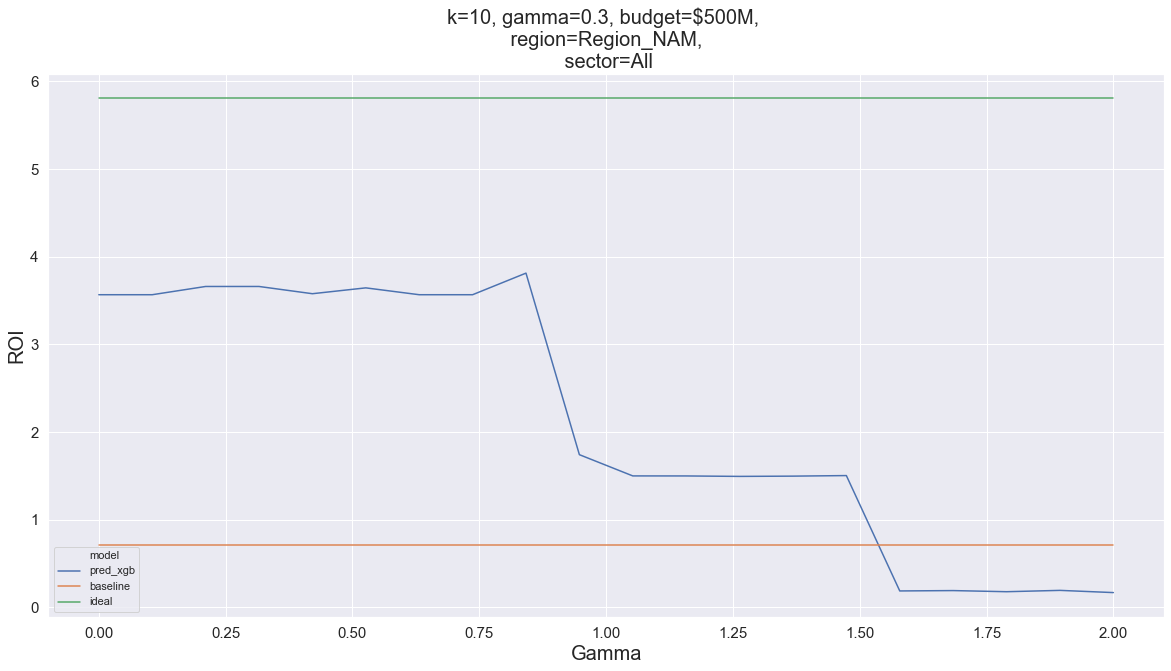

In [36]:
# rand, rand, rand
import matplotlib.pyplot as plt
import seaborn as sns

title="k={}, gamma={}, budget={}, \n region={}, \n sector=All"\
    .format("10",gamma,"$500M"," ".join(region),sector)

sns.set()
#sns.set_context("paper", font_scale=0.9)       
df_res=pd.DataFrame(result).set_index("gamma")
#df_res.to_csv("roi_budget_optim.csv")

df_res_stack=df_res.stack().reset_index().rename(columns={0:"val","level_1":"model"})
plt.figure(figsize=(20,10))
pl=sns.lineplot(data=df_res_stack, x="gamma", y="val", hue="model")
pl.set_xlabel("Gamma",fontsize=20)
pl.set_ylabel("ROI",fontsize=20)
plt.title(title,fontsize=20)
pl.tick_params(labelsize=15)
fig = pl.get_figure()
fig.savefig('inv_1.eps')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


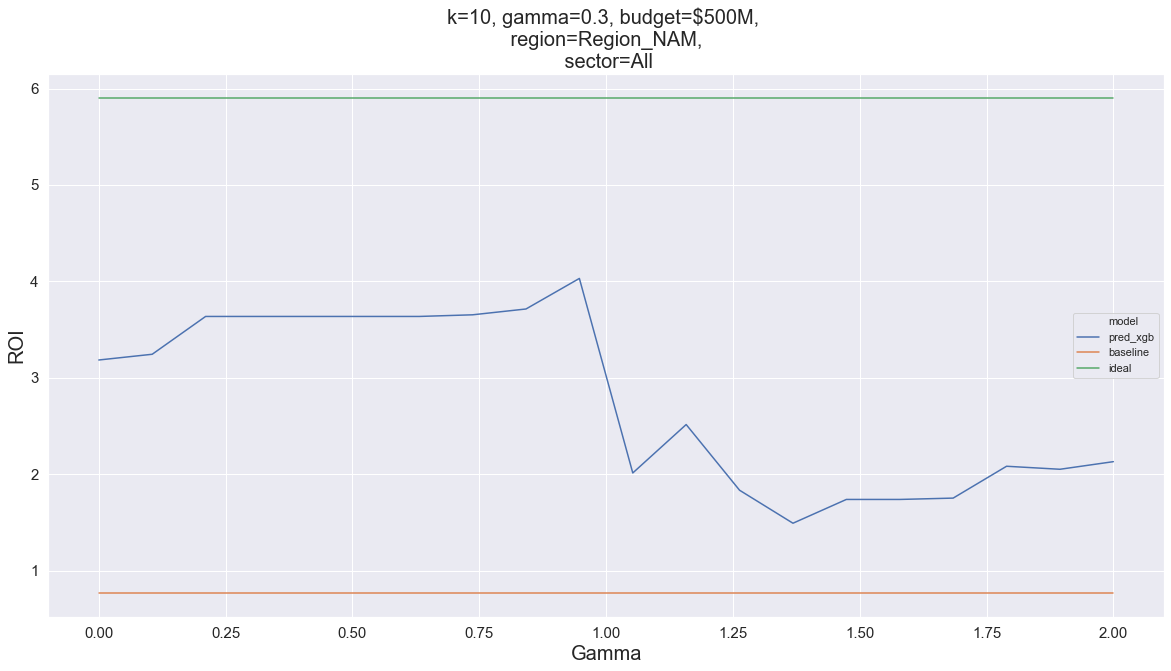

In [32]:
# 0.69, 0.69, 0.69
import matplotlib.pyplot as plt
import seaborn as sns

title="k={}, gamma={}, budget={}, \n region={}, \n sector=All"\
    .format("10",gamma,"$500M"," ".join(region),sector)

sns.set()
#sns.set_context("paper", font_scale=0.9)       
df_res=pd.DataFrame(result).set_index("gamma")
#df_res.to_csv("roi_budget_optim.csv")

df_res_stack=df_res.stack().reset_index().rename(columns={0:"val","level_1":"model"})
plt.figure(figsize=(20,10))
pl=sns.lineplot(data=df_res_stack, x="gamma", y="val", hue="model")
pl.set_xlabel("Gamma",fontsize=20)
pl.set_ylabel("ROI",fontsize=20)
plt.title(title,fontsize=20)
pl.tick_params(labelsize=15)
fig = pl.get_figure()
fig.savefig('inv_1.eps')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


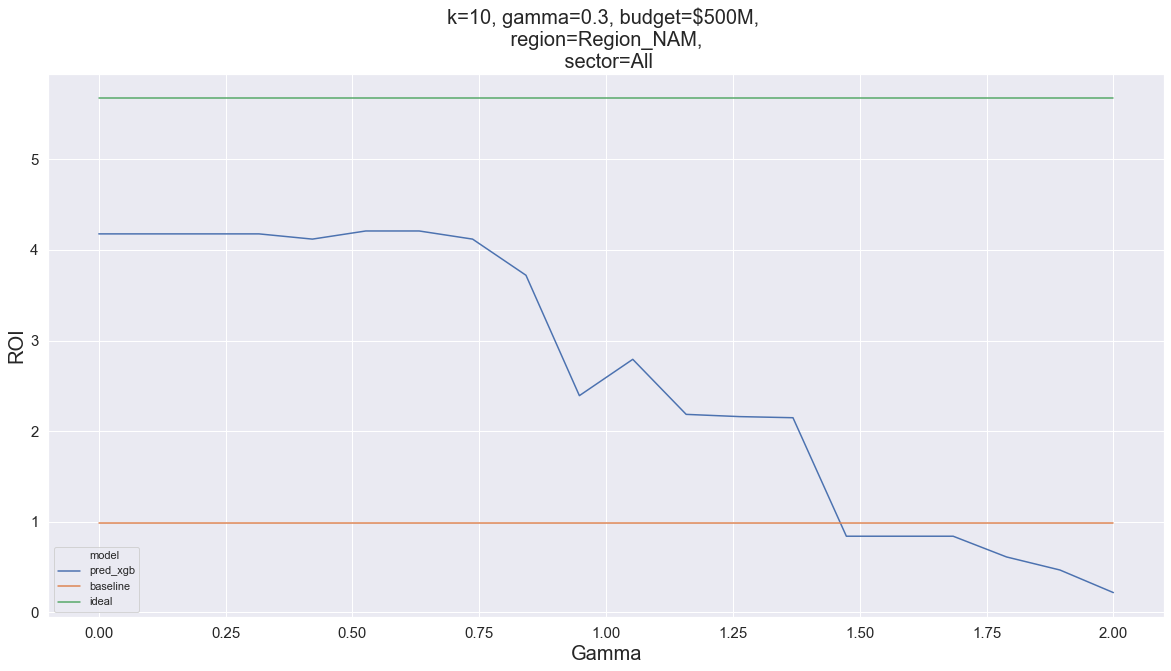

In [28]:
# 0.7, 0.85, 0.85
import matplotlib.pyplot as plt
import seaborn as sns

title="k={}, gamma={}, budget={}, \n region={}, \n sector=All"\
    .format("10",gamma,"$500M"," ".join(region),sector)

sns.set()
#sns.set_context("paper", font_scale=0.9)       
df_res=pd.DataFrame(result).set_index("gamma")
#df_res.to_csv("roi_budget_optim.csv")

df_res_stack=df_res.stack().reset_index().rename(columns={0:"val","level_1":"model"})
plt.figure(figsize=(20,10))
pl=sns.lineplot(data=df_res_stack, x="gamma", y="val", hue="model")
pl.set_xlabel("Gamma",fontsize=20)
pl.set_ylabel("ROI",fontsize=20)
plt.title(title,fontsize=20)
pl.tick_params(labelsize=15)
fig = pl.get_figure()
fig.savefig('inv_1.eps')
plt.show()


In [44]:
#opti_model("pred_lasso",data,gamma,n,sector,region,b,max_inv,min_inv)
#data[region].iloc[2].max()
#data["ARR_mean_cluster_XGBRegressor"]

Optimal


array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 2.1753084e+08, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [9]:
df_res

,pred_xgb,pred_rf,pred_cart,pred_lasso,pred_oct,baseline,ideal
gamma,,,,,,,
0.000000,5.821215,5.270714,3.780640,3.138548,5.316553,1.133166,7.406639
0.105263,6.057396,5.270714,3.780640,3.138548,5.316553,1.133166,7.406639
0.210526,5.821215,5.270714,3.810228,3.178333,5.316553,1.133166,7.406639
0.315789,5.821215,5.270714,3.806837,3.178333,5.316553,1.133166,7.406639
0.421053,5.821215,5.270714,3.806837,3.178333,5.316553,1.133166,7.406639
0.526316,5.904553,5.262751,4.019541,3.178333,5.326181,1.133166,7.406639
0.631579,5.904553,5.262751,3.971568,3.178333,5.785874,1.133166,7.406639
0.736842,5.904553,5.480189,3.971568,3.178333,5.271839,1.133166,7.406639
0.842105,5.376787,5.477610,3.335634,3.178333,4.150465,1.133166,7.406639


In [ ]:
df_res=pd.DataFrame(result)
plt.plot(df_res.budget,df_res.pred)
plt.plot(df_res.budget,df_res.baseline)
plt.plot(df_res.budget,df_res.ideal)

In [ ]:
from interpretableai import iai

path_sales= "./SalesProcessedDataSet_v2.csv"
x_col=['Region_APAC', 'Region_EU', 'Region_MEA', 'Region_NAM', 'Sector_Banks',
       'Sector_Chemicals, rubber, plastics, non-metallic products',
       'Sector_Construction', 'Sector_Education, Health',
       'Sector_Food, beverages, tobacco', 'Sector_Gas, Water, Electricity',
       'Sector_Hotels & restaurants', 'Sector_Insurance companies',
       'Sector_Machinery, equipment, furniture, recycling',
       'Sector_Metals & metal products', 'Sector_Other services',
       'Sector_Post and telecommunications',
       'Sector_Primary Sector (agriculture, mining, etc.)',
       'Sector_Public administration and defence',
       'Sector_Publishing, printing',
       'Sector_Textiles, wearing apparel, leather', 'Sector_Transport',
       'Sector_Wholesale & retail trade', 'Sector_Wood, cork, paper',
       'DealType_IPO', 'DealType_Minority stake', 'CompletedDate', 'Stake',
       'PreRevMult', 'PreEBITDAMult', 'PostRevMult', 'PostEBITDAMult',
       'PreRev', 'PreEBITDA', 'PostRev', 'PostEBITDA', 'LastRev',
       'LastRevPrev1', 'LastRevPrev2', 'LastEBITDA', 'LastEBITDAPrev1',
       'LastEBITDAPrev2', 'ValuationP0_S', 'ValuationP1_S', 'ValuationP2_S',
       'ValuationPreInvestment_S', 'ValuationAtInvestment_S','MarginEBITDAPrev1', 'MarginEBITDAPrev2',
       'PostMarginEBITDA']

ticket_size_df=pd.read_csv(path_sales)


In [ ]:
df=ticket_size_df
    #(ticket_size_df.TicketSize<10e9)\
              # &(ticket_size_df[sector]==1)\
               #  &(ticket_size_df[region]==1) 
                 

(train_X, train_treatments, train_outcomes), (test_X, test_treatments, test_outcomes) =\
iai.split_data("prescription_maximize",df[x_col], 
    df["TicketSize"], df["ROIY3_S"], seed =2)

In [ ]:
test_X.shape

In [12]:
data[['Region_APAC']].iloc[3].max()

0

In [16]:
[col for col in data if col.startswith('Sector')]

['Sector_Banks',
 'Sector_Chemicals, rubber, plastics, non-metallic products',
 'Sector_Construction',
 'Sector_Education, Health',
 'Sector_Food, beverages, tobacco',
 'Sector_Gas, Water, Electricity',
 'Sector_Hotels & restaurants',
 'Sector_Insurance companies',
 'Sector_Machinery, equipment, furniture, recycling',
 'Sector_Metals & metal products',
 'Sector_Other services',
 'Sector_Post and telecommunications',
 'Sector_Primary Sector (agriculture, mining, etc.)',
 'Sector_Public administration and defence',
 'Sector_Publishing, printing',
 'Sector_Textiles, wearing apparel, leather',
 'Sector_Transport',
 'Sector_Wholesale & retail trade',
 'Sector_Wood, cork, paper']

In [13]:
np.zeros(10)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])